In [ ]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

sys.path.insert(0, "..")

from unpast.misc.eval import calculate_perfromance
from unpast.misc.ds_synthetic_builder import ScenarioBiclusters  # , build_dataset
from unpast.run_unpast import unpast
from unpast.utils.io import read_bic_table, write_bic_table
from unpast.utils.visualization import plot_biclusters_heatmap

%matplotlib inline

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Simulated expression data

* 10000 features x 200 samples
* background ~Norm(0,1), bicluster ~ Norm(4,1)
* four biclusters with fraction [0.05,0.1,0.25,0.5] of all columns (samples) simulate four subtypes

* Complexity:
    - Simple: n=500 features per bicluster 
    - Features: n=5 features per bicluster 
* Scenarios:
    - A: biclusters do not overlap
    - B: random overlaps in samples
    - C: random overlaps in samples + co-expression modules in the background
    
    
* co-expression modules of user-defined size with avg. Pearson r about 0.5 added to the background


In [2]:
seed = 42
output_folder = Path("test_data_sim/")


# dimensions of the matrix  (genes, samples)
size = (10000, 200)
common_args = {
    # bicluster expression parameters
    "m": 4,
    "std": 1,
    # fractions of samples included to each subtype
    "frac_samples": [0.05, 0.1, 0.25, 0.5],
}

# Generate four test datasets:

(5,500) x (A,C)

## number of features in each bicluster (i.e. biomarkers) 
* 5, 50, or 500 features in each bicluster 

## Scenario A
* non-overlapping feature and sample clusters 
* background contains no signal

## Scenario B
* same as A, but with overlapping sample clusters 
* (not tested)

## Scenario C 
* overlapping sample clusters, non-overlapping in features 
* four 500-feature co-expression modules added to the background

*! only 2000 background genes are shown in the figures

In [3]:
# number of biomarkers, i.e. features in biclusters
n_features_per_bic = [5, 50, 500]

# scenarios
scenarios = ["A", "C"]

# parameters for scenarios A and C
scenario_args = {
    "A": {"add_coexpressed": [], "g_overlap": False, "s_overlap": False},
    "B": {"add_coexpressed": [], "g_overlap": False, "s_overlap": True},
    "C": {
        "add_coexpressed": [500]
        * 4,  # add 4 co-expression modules of 500 genes each, with avg. r=0.5
        "g_overlap": False,
        "s_overlap": True,
    },
}

Building data for A_5


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:190: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


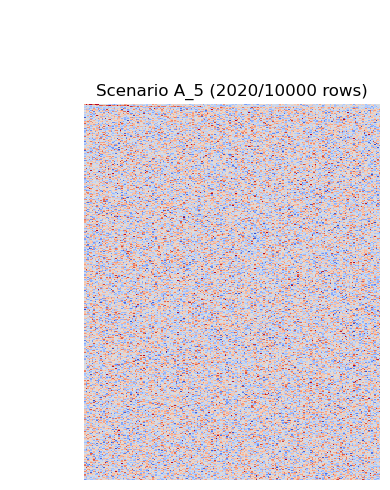

Building data for C_5


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:190: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


	co-exprs. module 500 features, avg. pairwise r=0.51
	co-exprs. module 500 features, avg. pairwise r=0.52
	co-exprs. module 500 features, avg. pairwise r=0.46
	co-exprs. module 500 features, avg. pairwise r=0.57


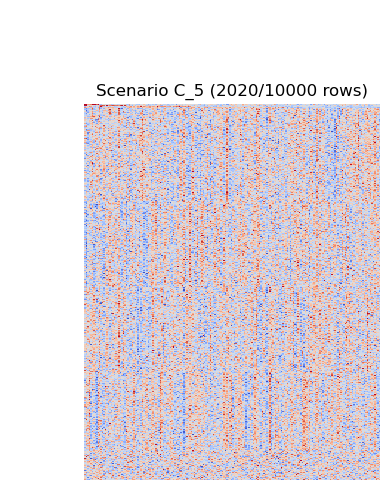

Building data for A_50


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:190: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


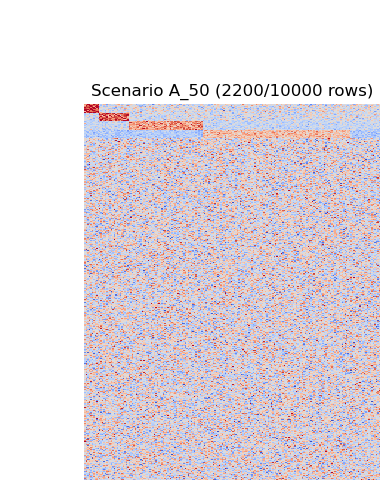

Building data for C_50


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:190: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


	co-exprs. module 500 features, avg. pairwise r=0.56
	co-exprs. module 500 features, avg. pairwise r=0.51
	co-exprs. module 500 features, avg. pairwise r=0.46
	co-exprs. module 500 features, avg. pairwise r=0.58


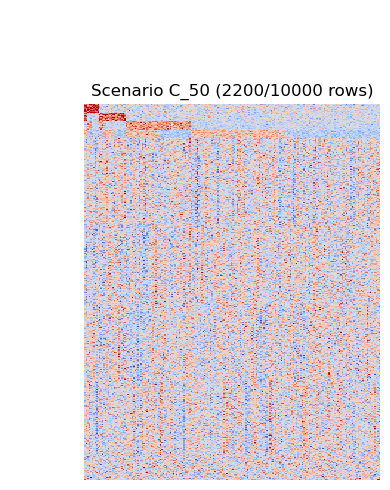

Building data for A_500


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:190: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


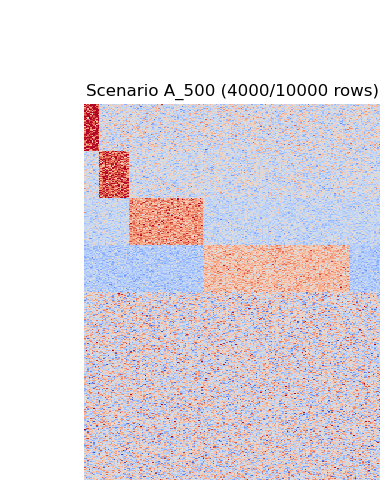

Building data for C_500


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:190: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


	co-exprs. module 500 features, avg. pairwise r=0.46
	co-exprs. module 500 features, avg. pairwise r=0.55
	co-exprs. module 500 features, avg. pairwise r=0.50
	co-exprs. module 500 features, avg. pairwise r=0.49


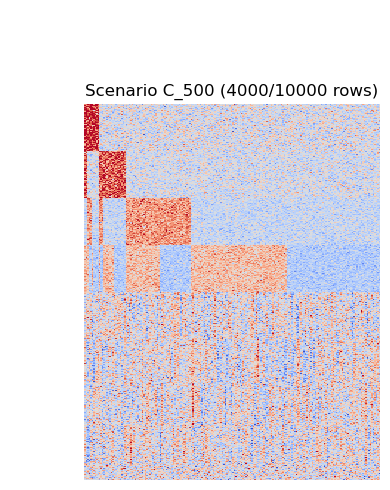

In [4]:
for n_biomarkers in n_features_per_bic:
    for sc_name in scenarios:
        scenario = f"{sc_name}_{n_biomarkers}"
        print(f"Building data for {scenario}")

        # generate input data and ground truth
        # and save to files <outdir>/<outfile_basename>*
        data, ground_truth, extra = ScenarioBiclusters(
            size,
            g_size=n_biomarkers,
            **common_args,
            **scenario_args[sc_name],
        ).build(seed)
        coexpressed_modules = extra["coexpressed_modules"]

        # save
        (output_folder / scenario).mkdir(parents=True, exist_ok=True)
        exprs_file = output_folder / scenario / "data.tsv"
        bicluster_file = output_folder / scenario / "true_biclusters.tsv"
        data.to_csv(exprs_file, sep="\t")
        write_bic_table(ground_truth, str(bicluster_file))

        # plot heatmaps
        plot_biclusters_heatmap(
            data,
            ground_truth,
            coexpressed_modules=coexpressed_modules,
            fig_title="Scenario " + scenario,
            fig_path=output_folder / "img" / f"Fig_{scenario}.png",
            limit_features=4 * n_biomarkers + 2000,  # don't show too much background
        )
        # plt.show()
        # save ground truth as bicluster file

# UnPaSt Evaluation

(example - С_500)

* run unpast with a fixed seed
* clust_method="Louvain" - to avoid problems with R

In [5]:
data_folder = str(output_folder) + "/"

# input file name
scenario = "A_5"
data_file = output_folder / scenario / "data.tsv"
print(data_file)
pd.read_csv(data_file, sep="\t", index_col=0).head(3)

test_data_sim/A_5/data.tsv


,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_190,s_191,s_192,s_193,s_194,s_195,s_196,s_197,s_198,s_199
g_0,0.577318,-0.104719,0.739481,1.679693,-0.207714,-0.207696,1.740040,0.868101,-0.460474,0.626561,...,-0.435813,0.963658,0.273753,-1.294267,0.229808,0.457665,-0.905567,0.208910,0.106315,-1.183883
g_1,0.275500,0.481170,1.010313,0.980679,-1.482808,-1.037173,0.434818,0.433552,0.434831,3.816463,...,-0.997243,0.411398,-1.424616,1.768575,1.107971,-0.562352,-1.822691,1.284700,-0.203047,1.167116
g_2,-1.517816,-0.516799,0.091444,0.133431,-0.366595,0.712752,-0.987851,-0.057064,0.207185,0.603691,...,0.158164,-0.394352,0.568019,0.421830,1.129927,-0.426905,-0.185324,-0.898462,-0.360788,0.465730


In [6]:
# read ground truth biclusters from files
biclusters_file_name = output_folder / scenario / "true_biclusters.tsv"
print(biclusters_file_name)
true_biclusters = read_bic_table(str(biclusters_file_name))
true_biclusters

test_data_sim/A_5/true_biclusters.tsv


,genes,samples,frac,n_genes,n_samples,sample_indexes,gene_indexes,genes_up,genes_down,SNR
id,,,,,,,,,,
bic_0.05,"{g_4187, g_1837, g_7730, g_4754, g_9921}","{s_87, s_66, s_171, s_17, s_57, s_143, s_82, s...",0.05,5,10,"{66, 165, 134, 171, 143, 17, 82, 87, 57, 159}","{9921, 1837, 4754, 7730, 4187}","{g_4187, g_1837, g_7730, g_4754, g_9921}",{},4.023803
bic_0.1,"{g_3476, g_9690, g_4380, g_8312, g_8752}","{s_5, s_182, s_150, s_9, s_0, s_170, s_130, s_...",0.10,5,20,"{0, 130, 5, 9, 11, 150, 26, 161, 168, 170, 49,...","{8752, 3476, 8312, 9690, 4380}","{g_3476, g_9690, g_4380, g_8312, g_8752}",{},3.632381
bic_0.25,"{g_8214, g_176, g_4059, g_9041, g_5023}","{s_174, s_198, s_56, s_94, s_142, s_151, s_14,...",0.25,5,50,"{128, 129, 2, 132, 6, 137, 141, 14, 142, 144, ...","{176, 9041, 8214, 4059, 5023}","{g_8214, g_176, g_4059, g_9041, g_5023}",{},3.570585
bic_0.5,"{g_2096, g_2838, g_5846, g_2890, g_9486}","{s_7, s_148, s_79, s_147, s_48, s_1, s_89, s_1...",0.50,5,100,"{1, 4, 7, 8, 10, 12, 15, 16, 18, 19, 21, 22, 2...","{2890, 9486, 2096, 5846, 2838}","{g_2096, g_2838, g_5846, g_2890, g_9486}",{},3.726347


## Performance measures 
* Feature and sample set evaluation:
    * wARIs - sum of sample ARIs of all matched biclusters weighted by their prevalence
    * F1_f_avg, F1_s_avg -  F1 for features/samples of best matching biclusters, averaged across four biclusters
    
* For all biclusters:
    * FDR_bics  - FDR = FP/(TP+FP) - fraction of wrongly biclustered elements in among all predicted biclusters  
    * Recall_bics - Recall = TP/P - fractoion of correctly biclustered elements in among all true bicluster

In [7]:
def add_performance_cols(
    best_matches_, true_biclusters, pred_biclusters, target="genes", all_samples={None}
):
    best_matches = best_matches_.loc[:, :].copy()

    best_matches.loc[best_matches["bm_id"].dropna().index, "pred_" + target] = (
        best_matches["bm_id"].dropna().apply(lambda x: pred_biclusters.loc[x, target])
    )
    best_matches.loc[:, "pred_" + target] = best_matches.loc[
        :, "pred_" + target
    ].fillna("")
    best_matches.loc[best_matches["pred_" + target] == "", "pred_" + target] = (
        best_matches.loc[best_matches["pred_" + target] == "", "pred_" + target].apply(
            lambda x: set([])
        )
    )

    if target == "samples":
        best_matches.loc[best_matches["is_enriched"] == False, "pred_" + target] = (
            best_matches.loc[
                best_matches["is_enriched"] == False, "pred_" + target
            ].apply(lambda x: all_samples.difference(x))
        )
    best_matches["bic_id"] = best_matches.index
    best_matches["true_" + target] = best_matches["bic_id"].apply(
        lambda x: true_biclusters.loc[x, target]
    )

    best_matches["TP_" + target] = best_matches.apply(
        lambda row: row["true_" + target].intersection(row["pred_" + target]), axis=1
    )
    # true positive rate == Recall
    best_matches["TPR_" + target] = best_matches.apply(
        lambda row: len(row["TP_" + target]) / len(row["true_" + target]), axis=1
    )

    # precision
    best_matches["Prec_" + target] = 0.0
    non_zero = best_matches["pred_" + target].apply(len) > 0
    best_matches.loc[non_zero, "Prec_" + target] = best_matches.loc[non_zero, :].apply(
        lambda row: len(row["TP_" + target]) / len(row["pred_" + target]), axis=1
    )

    # keep only biclusters matching anything
    best_matches["F1_" + target] = 0.0
    mbic_ids = best_matches["Prec_" + target] + best_matches["TPR_" + target]
    mbic_ids = mbic_ids[mbic_ids > 0].index.values

    prec = best_matches.loc[mbic_ids, "Prec_" + target] * 1.0
    rec = best_matches.loc[mbic_ids, "TPR_" + target] * 1.0
    pr = prec + rec
    best_matches.loc[mbic_ids, "F1_" + target] = 2.0 * np.multiply(prec, rec) / pr

    return best_matches


def calc_performance_measures(best_matches_, true_biclusters, pred_biclusters, exprs):
    best_matches = add_performance_cols(
        best_matches_,
        true_biclusters,
        pred_biclusters,
        target="samples",
        all_samples=set(exprs.columns.values),
    )

    best_matches = add_performance_cols(
        best_matches, true_biclusters, pred_biclusters, target="genes"
    )

    F1_f_avg = best_matches["F1_genes"].sum() / true_biclusters.shape[0]
    F1_s_avg = best_matches["F1_samples"].sum() / true_biclusters.shape[0]

    # FP in matched biclusters
    # number of elements in matched biclusters not in true biclusters
    df = best_matches
    pred_P_matched = df["pred_genes"].apply(len) * df["pred_samples"].apply(len)
    TP = df["TP_genes"].apply(len) * df["TP_samples"].apply(len)
    FP1 = pred_P_matched - TP

    #  number of elements in non-matched biclusters
    bm_ids = list(set(best_matches["bm_id"].values))
    not_mbic_ids = [x for x in pred_biclusters.index if not x in bm_ids]
    df2 = pred_biclusters.loc[not_mbic_ids, :]
    FP2 = df2["n_genes"] * df2["n_samples"]

    FP = FP2.sum() + FP1.sum()

    # ratio of predicted bicluster elements (FP) not matching true biclusters, to all biclusters predicted elements (TP+FP)
    P = true_biclusters["n_genes"] * true_biclusters["n_samples"]
    P = P.sum()
    # FDR
    FDR_bic = FP / (TP.sum() + FP)

    # Recall
    Recall_bic = TP.sum() / P

    return best_matches, F1_f_avg, F1_s_avg, FDR_bic, Recall_bic

# Run unpast for all test scenarios

In [12]:
for n_biomarkers in n_features_per_bic:
    for sc_name in scenarios:
        scenario = sc_name + "_" + str(n_biomarkers)
        print(scenario)
        # input file name
        data_file = output_folder / scenario / "data.tsv"

        ### run unpast ###
        print("running unpast for %s" % data_file)
        out_dir = output_folder / "unpast_runs" / f"run_{scenario}.predicted"

        # predicted biclusters
        pred_biclusters = unpast(
            str(data_file),
            out_dir=str(out_dir),
            clust_method="Louvain",
            seed=seed,
            verbose=False,
        )
        print(f"{scenario} biclusters detected:{pred_biclusters.shape[0]}")
        biclusters_file_name = out_dir / scenario / "pred_biclusters.tsv"
        print(f"saving to {biclusters_file_name}")
        biclusters_file_name.parent.mkdir(parents=True, exist_ok=True)
        write_bic_table(pred_biclusters, str(biclusters_file_name))

A_5
running unpast for test_data_sim/A_5/data.tsv
2025-09-15 20:55:39UTC   222015ms    INFO  Loaded input from test_data_sim/A_5/data.tsv
2025-09-15 20:55:39UTC   222015ms    INFO  - input shape = 10000 features x 200 samples
2025-09-15 20:55:40UTC   222079ms    INFO    Binarization directory /Users/savmac/proj/Biclustering/unpast/notebooks/test_data_sim/unpast_runs/run_A_5.predicted/binarization already exist, trying to load precalculated binarization files.
2025-09-15 20:55:42UTC   224896ms    INFO  Biclusters saved to /Users/savmac/proj/Biclustering/unpast/notebooks/test_data_sim/unpast_runs/run_A_5.predicted/biclusters.tsv
2025-09-15 20:55:42UTC   224897ms    INFO  - found 9 biclusters with shapes: 6x84, 5x100, 4x94, 5x50, 2x99, 2x98, 2x96, 2x94, 2x84
A_5 biclusters detected:9
saving to test_data_sim/unpast_runs/run_A_5.predicted/A_5/pred_biclusters.tsv
C_5
running unpast for test_data_sim/C_5/data.tsv
2025-09-15 20:55:43UTC   225193ms    INFO  Loaded input from test_data_sim/C_5/d

# Evaluate all pre-computed biclusters 

In [15]:
performances = {}
suffix = ".bin=kmeans,pval=0.01,clust=Louvain,direction=DOWN-UP,m=0.33.biclusters.tsv"
suffix = ".seed=" + str(42) + suffix

for n_biomarkers in n_features_per_bic:
    for sc_name in scenarios:
        scenario = sc_name + "_" + str(n_biomarkers)
        print(scenario)

        # read pre-computed (predicted) biclusters
        basename = scenario + ".predicted"
        predicted_dir = data_folder + f"/unpast_runs/run_{scenario}.predicted"
        pred_biclusters = read_bic_table(predicted_dir + "/biclusters.tsv")

        print(scenario, "found biclusters: %s" % pred_biclusters.shape[0])

        # read data
        data_file = output_folder / scenario / "data.tsv"
        print(f"use data file from {data_file}")
        data = pd.read_csv(data_file, sep="\t", index_col=0)
        # true biclusters

        # read ground truth biclusters from files
        biclusters_file_name = output_folder / scenario / "true_biclusters.tsv"
        true_biclusters = read_bic_table(str(biclusters_file_name))
        print(biclusters_file_name)

        # Finding best matches and estimating performance
        all_samples = set(data.columns.values)  # all samples in the dataset
        known_groups = true_biclusters.loc[:, ["samples"]].to_dict()["samples"]
        known_groups = {
            "true_biclusters": known_groups
        }  # can be more than one classification => it is a dict of dicts

        res, best_matches = calculate_perfromance(
            pred_biclusters, known_groups, all_samples, performance_measure="ARI"
        )
        # sum of per-bicluster ARIs, weighted proporionally to the bicluster frequency
        wARIs = res["true_biclusters"]
        best_matches, F1_f_avg, F1_s_avg, FDR_bic, Recall_bic = (
            calc_performance_measures(
                best_matches.dropna(), true_biclusters, pred_biclusters, data
            )
        )
        performances[scenario] = {
            "wARIs": wARIs,
            "F1_f_avg": F1_f_avg,
            "F1_s_avg": F1_s_avg,
            "FDR_bic": FDR_bic,
            "Recall_bic": Recall_bic,
        }
performances = pd.DataFrame.from_dict(performances).T
performances.to_csv("performances.tsv", sep="\t")
performances

A_5
A_5 found biclusters: 9
use data file from test_data_sim/A_5/data.tsv
test_data_sim/A_5/true_biclusters.tsv
C_5
C_5 found biclusters: 19
use data file from test_data_sim/C_5/data.tsv


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/eval.py:211: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pvals = pvals.applymap(lambda x: min(x, 1))


test_data_sim/C_5/true_biclusters.tsv
A_50
A_50 found biclusters: 10
use data file from test_data_sim/A_50/data.tsv


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/eval.py:211: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pvals = pvals.applymap(lambda x: min(x, 1))


test_data_sim/A_50/true_biclusters.tsv
C_50
C_50 found biclusters: 7
use data file from test_data_sim/C_50/data.tsv


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/eval.py:211: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pvals = pvals.applymap(lambda x: min(x, 1))


test_data_sim/C_50/true_biclusters.tsv
A_500
A_500 found biclusters: 7
use data file from test_data_sim/A_500/data.tsv


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/eval.py:211: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pvals = pvals.applymap(lambda x: min(x, 1))


test_data_sim/A_500/true_biclusters.tsv
C_500
C_500 found biclusters: 11
use data file from test_data_sim/C_500/data.tsv


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/eval.py:211: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pvals = pvals.applymap(lambda x: min(x, 1))


test_data_sim/C_500/true_biclusters.tsv


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/eval.py:211: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pvals = pvals.applymap(lambda x: min(x, 1))


,wARIs,F1_f_avg,F1_s_avg,FDR_bic,Recall_bic
A_5,0.838087,0.500000,0.628788,0.790034,0.833333
C_5,0.822222,0.500000,0.498744,0.870345,0.827778
A_50,0.944947,0.580808,0.795455,0.471393,0.850000
C_50,0.944444,0.588599,0.750000,0.519231,0.866667
A_500,1.000000,0.620297,1.000000,0.010042,0.863111
C_500,0.944444,0.514914,0.750000,0.028590,0.740333


In [16]:
thresholds = pd.DataFrame(
    {
        "A_5": [0.8, 0.5, 0.6, 0.75, 0.8],
        "C_5": [0.8, 0.4, 0.45, 0.85, 0.8],
        "A_50": [0.9, 0.5, 0.7, 0.4, 0.8],
        "C_50": [0.9, 0.5, 0.7, 0.5, 0.8],
        "A_500": [0.9, 0.6, 0.7, 0.01, 0.85],
        "C_500": [0.9, 0.5, 0.7, 0.02, 0.7],
    },
    index=["wARIs", "F1_f_avg", "F1_s_avg", "FDR_bic", "Recall_bic"],
).T
quality_check = performances >= thresholds
display(quality_check)

assert quality_check.all().all()

,wARIs,F1_f_avg,F1_s_avg,FDR_bic,Recall_bic
A_5,True,True,True,True,True
C_5,True,True,True,True,True
A_50,True,True,True,True,True
C_50,True,True,True,True,True
A_500,True,True,True,True,True
C_500,True,True,True,True,True
